In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

import dask.dataframe as ddf
import dask.multiprocessing

from pandas.core.dtypes.dtypes import CategoricalDtype # <-
from scipy.stats import norm, skew
from scipy.special import boxcox1p

from scipy import stats
from scipy.stats import expon, reciprocal
from scipy.stats import randint

from collections import Counter
from pandas.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression


%matplotlib inline

def nl():
    print('\n')

# Introduction
- 以下はある企業のオープンデータセットになっており、このNotebookでおこなっている事はある程度の規模のデータセットのデータクリーニングをどのように行えばよいか、という問題を主題としています。
- まずデータセットはindex:40,000,000, 2.3G である為に、メモリ増設を行っていないorデフォルトでメモリが少ないPCでは処理後のデータ全体や処理中のデータがメモリ領域に乗りきらないという問題が存在し、Error32等が発生する可能性があります。これらを解決する為の方法として、データを少しづつ読み不要になった変数を削除するか等の方法が存在します。
- このNotebookではDASKライブラリのDataFrameを使用してデータの読み込みとデータ処理を行うという方法で上記の問題を解決しながら、その処理速度を上げるという事を行っています。
- このNotebookではデータ処理に焦点を当てているので予測モデルの作成は行っていません。EDAも行っていません。

# DataSetについて
- このコンペティションでは、ある商品の、ある店舗での、ある週の需要を予測することになります。あなたに与えられたデータセットは、メキシコでの9週間の販売取引から構成されています。毎週、商品をベンダーに届ける配送トラックがあります。各取引は、売上と返品から構成される。返品は売れ残りや賞味期限切れの商品である。ある週の商品の需要は、今週の売上から来週の返品を差し引いたものと定義される。

- 訓練データセットとテストデータセットは時間に基づいて分割されている。

# 注意すべきこと

- テストセットには、訓練セットに存在しない商品がある。これはインベントリデータで予想される動作で、常に新しい製品が販売されているからです。モデルを作成する場合にはこれに対応できるようにする必要があります。
- cliente_tablaに重複したCliente_IDがあります。つまり、1つのCliente_IDが非常に類似した複数のNombreClienteを持つ可能性があります。これは、NombreCliente が生データではノイズが多く、標準化されていないためで、この情報をどのようにクリーンアップして使用するかはデータサイエンティスト次第。
- 需要は0か正の値であるべきなので、調整後の需要（Demanda_uni_equil）は常に≧0となります。Venta_uni_hoy - Dev_uni_proxima が時々マイナスの値になるのは、リターンの記録が時々数週間繰り越されるからである。

# ファイルの説明
- train.csv - 訓練セット
- test.csv - テストセット
- sample_submission.csv - 正しいフォーマットのサンプル投稿ファイルです。
- cliente_tabla.csv - 顧客名 (Cliente_ID で train/test と結合可能)
- producto_tabla.csv - 製品名 (Producto_IDでtrain/testと結合可能)
- town_state.csv - 町および州 (Agencia_ID の train/test で結合可能)

# データフィールド
- Semana - 週番号 (木曜日から水曜日まで)
- Agencia_ID-販売代理店ID
- Canal_ID-販売チャンネルID
- Ruta_SAK-ルートID（複数のルート＝販売拠点）。
- Cliente_ID-クライアントID
- NombreCliente - クライアント名
- Producto_ID - 製品ID
- NombreProducto - 製品名
- Venta_uni_hoy - 今週の販売台数 (整数)
- Venta_hoy - 今週の売上(単位：ペソ)
- Dev_uni_proxima - 来週の返品単位 (整数)
- Dev_proxima - 来週の売上高（単位：ペソ）
- Demanda_uni_equil - 調整済み需要（整数）（これは予測する目標です。）

## Client_table : 顧客名 (Cliente_ID で train/test と結合可能)
- Cliente_ID-クライアントID
- NombreCliente - クライアント名

In [2]:
dtype = {'Cliente_ID': 'int32'}
client_df = pd.read_csv('D:/JupyterNotebook/BakeryDataset/cliente_tabla.csv', dtype=dtype)

In [3]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935362 entries, 0 to 935361
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Cliente_ID     935362 non-null  int32 
 1   NombreCliente  935362 non-null  object
dtypes: int32(1), object(1)
memory usage: 10.7+ MB


In [4]:
client_df.head(2)

,Cliente_ID,NombreCliente
0,0,SIN NOMBRE
1,1,OXXO XINANTECATL


In [5]:
dup_sr = client_df.groupby('Cliente_ID')['Cliente_ID'].count().astype('int8')
dup_sr.name = 'dup_num'
client_df = pd.merge(client_df, pd.DataFrame(dup_sr).reset_index())

In [6]:
del dup_sr # 不要になった変数を開放する為に削除.

In [7]:
print(f'client\'s shape: {client_df.shape}')
client_df.head(3)

client's shape: (935362, 3)


,Cliente_ID,NombreCliente,dup_num
0,0,SIN NOMBRE,1
1,1,OXXO XINANTECATL,1
2,2,SIN NOMBRE,1


------
## producto_tabla : 製品名 (Producto_IDでtrain/testと結合可能)
- Producto_ID - 製品ID
- NombreProducto - 製品名

In [8]:
dtype = {'Producto_ID': 'int32'}
product_df = pd.read_csv('D:/JupyterNotebook/BakeryDataset/producto_tabla.csv')

In [9]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592 entries, 0 to 2591
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Producto_ID     2592 non-null   int64 
 1   NombreProducto  2592 non-null   object
dtypes: int64(1), object(1)
memory usage: 40.6+ KB


In [10]:
product_df.head(2)

,Producto_ID,NombreProducto
0,0,NO IDENTIFICADO 0
1,9,Capuccino Moka 750g NES 9


In [11]:
product_df['popular_name'] = product_df.NombreProducto.str.extract(r'^(.*?)(\d*\s\d+(kg|Kg|g|G|ml| ml|p|Reb)\s)', expand=False)[0]
product_df['property'] = product_df.NombreProducto.str.extract(r'^.*\d+(kg|Kg|g|G|ml| ml|p|Reb)\s(.*?)\s\d+$', expand=False)[1]
product_df['unit'] = product_df.NombreProducto.str.extract(r'(\d*\s\d+(kg|Kg|g|G|ml| ml))', expand=False)[0]
product_df['pieces'] =  product_df.NombreProducto.str.extract('(\d+(p|Reb)) ', expand=False)[0]

In [12]:
print(f'product\'s shape: {product_df.shape}')
product_df.head(5)

product's shape: (2592, 6)


,Producto_ID,NombreProducto,popular_name,property,unit,pieces
0,0,NO IDENTIFICADO 0,NaN,NaN,NaN,NaN
1,9,Capuccino Moka 750g NES 9,Capuccino Moka,NES,750g,NaN
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41,Bimbollos Ext sAjonjoli,BIM,480g,6p
3,53,Burritos Sincro 170g CU LON 53,Burritos Sincro,CU LON,170g,NaN
4,72,Div Tira Mini Doradita 4p 45g TR 72,Div Tira Mini Doradita,TR,45g,4p


------
## town_state.csv : 町および州 (Agencia_ID の train/test で結合可能)
- Agencia_ID-販売代理店ID
- Town - 町
- State - 州

In [13]:
dtype = {'Agencia_ID': 'int16'}
town_state_df = pd.read_csv('D:/JupyterNotebook/BakeryDataset/town_state.csv', dtype=dtype)

In [14]:
town_state_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Agencia_ID  790 non-null    int16 
 1   Town        790 non-null    object
 2   State       790 non-null    object
dtypes: int16(1), object(2)
memory usage: 14.0+ KB


In [15]:
town_state_df.head(3)

,Agencia_ID,Town,State
0,1110,2008 AG. LAGO FILT,"MÉXICO, D.F."
1,1111,2002 AG. AZCAPOTZALCO,"MÉXICO, D.F."
2,1112,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO


In [16]:
town_state_df['Town_ID'] = town_state_df.Town.apply(lambda x: x.split(' ')[0]).astype('int16')
town_state_df['Town_name'] = town_state_df.Town.apply(lambda x: ' '.join(x.split(' ')[1:]))

In [17]:
print(f'town_state\'s shape: {town_state_df.shape}')
town_state_df.head(3)

town_state's shape: (790, 5)


,Agencia_ID,Town,State,Town_ID,Town_name
0,1110,2008 AG. LAGO FILT,"MÉXICO, D.F.",2008,AG. LAGO FILT
1,1111,2002 AG. AZCAPOTZALCO,"MÉXICO, D.F.",2002,AG. AZCAPOTZALCO
2,1112,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO,2004,AG. CUAUTITLAN


-----
## test.csv : テストセット
- test_df : nrows(500000)
- test_ddf : ALL DATA DASK

In [18]:
dtype = {
    'id': 'int32',
    'Semana': 'int8',
    'Agencia_ID': 'int16',
    'Canal_ID': 'int8',
    'Ruta_SAK': 'int16',
    'Cliente_ID': 'int32',
    'Producto_ID': 'int32',
}
test_df = pd.read_csv('D:/JupyterNotebook/BakeryDataset/test.csv', dtype=dtype, nrows=20000000) # ALL DATA 40,000,000 chinksize=

In [19]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999251 entries, 0 to 6999250
Data columns (total 7 columns):
 #   Column       Dtype
---  ------       -----
 0   id           int32
 1   Semana       int8 
 2   Agencia_ID   int16
 3   Canal_ID     int8 
 4   Ruta_SAK     int16
 5   Cliente_ID   int32
 6   Producto_ID  int32
dtypes: int16(2), int32(3), int8(2)
memory usage: 120.2 MB


In [20]:
test_df.head(2)

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID
0,0,11,4037,1,2209,4639078,35305
1,1,11,2237,1,1226,4705135,1238


In [21]:
print(f'test\'s shape: {test_df.shape}') # out-line

test's shape: (6999251, 7)


In [22]:
test_ddf = ddf.read_csv('D:/JupyterNotebook/BakeryDataset/test.csv', blocksize=25e6)

In [23]:
test_ddf.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 7 entries, id to Producto_ID
dtypes: int64(7)

In [24]:
test_ddf.head(1)

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID
0,0,11,4037,1,2209,4639078,35305


-------
## train.csv : 訓練セット
- Semana - 週番号 (木曜日から水曜日まで)
- Agencia_ID-販売代理店ID
- Canal_ID-販売チャンネルID
- Ruta_SAK-ルートID（複数のルート＝販売拠点）。
- Cliente_ID-クライアントID
- NombreCliente - クライアント名
- Producto_ID - 製品ID
- NombreProducto - 製品名
- Venta_uni_hoy - 今週の販売台数 (整数)
- Venta_hoy - 今週の売上(単位：ペソ)
- Dev_uni_proxima - 来週の返品単位 (整数)
- Dev_proxima - 来週の売上高（単位：ペソ）
- Demanda_uni_equil - 調整済み需要（整数）（これは予測する目標です。）

- 各行が商品Product_IDの商品数によって各Client_IDが単一という形になっている。
- Demande_uni_equilを予測する訳だが、Venta_uni_hoyという特徴量が今週の販売数であるので、これは正確に予測をする場合、時間周期性を考慮に入れる必要がある為、このデータ単体とその地域の時系列の人流を使用する必要があると考えられる。地域人流、年齢動態その他を考慮する事によってより正確な予測を行えると思われる。

- 時系列として週が数値にカテゴライズされて存在するが、データセットを全て表示していない場合、データとして不十分な状態になる。

- ルートが存在するので、グラフ理論を使用する事が可能であるとも考えられる。
- Agencia_ID-販売代理店ID, Canal_ID-販売チャンネルIDの違いが何を示しているのか現状不明。

In [25]:
dtype = {
    'Semana': 'int8',
    'Agencia_ID': 'int16',
    'Canal_ID': 'int8',
    'Ruta_SAK': 'int16',
    'Cliente_ID': 'int32',
    'Producto_ID': 'int32',
    'Venta_uni_hoy': 'int16',
    'Venta_hoy': 'float32',
    'Dev_uni_proxima': 'int32',
    'Dev_proxima': 'float32',
    'Demanda_uni_equil': 'int16',
}
train_df = pd.read_csv('D:/JupyterNotebook/BakeryDataset/train.csv', dtype=dtype, nrows=20000000) # All is not read, nrows=500000, chunksize=100000

In [26]:
#test_load_4_pd = pd.DataFrame([])
#for chunk in test_load_4:
#    test_load_4_pd = test_load_4_pd.add(chunk)

In [27]:
print(f'train\'s shape: {train_df.shape}') # train_df
train_df.head(2) # train_df

train's shape: (20000000, 11)


,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1110,7,3301,15766,1212,3,25.139999,0,0.0,3
1,3,1110,7,3301,15766,1216,4,33.520000,0,0.0,4


In [28]:
train_ddf = ddf.read_csv('D:/JupyterNotebook/BakeryDataset/train.csv', blocksize=25e6) # train_df or train_ddf

In [29]:
train_ddf.head(3)

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4


In [30]:
train_ddf['Semana'].unique().compute() # 3456789

0    3
1    4
2    5
3    6
4    7
5    8
6    9
Name: Semana, dtype: int64

> ProductPrice

In [31]:
sale_price_sr = (train_ddf.Venta_hoy / train_ddf.Venta_uni_hoy)
return_price_sr = (train_ddf.Dev_proxima / train_ddf.Dev_uni_proxima)
product_price_df = pd.DataFrame({'Producto_ID': train_ddf.Producto_ID, 'sale_price': sale_price_sr, 'return_price': return_price_sr})

del sale_price_sr
del return_price_sr

In [32]:
print(f'product price\'s shape: {product_price_df.shape}') # ALL DATA shape:(74180464,) 
product_price_df.head(3)

product price's shape: (74180464, 3)


,Producto_ID,sale_price,return_price
0,1212,8.38,NaN
1,1216,8.38,NaN
2,1238,9.83,NaN


-----
-----
# Pre-Process 

### town_state

In [33]:
town_state_df.isnull().sum()

Agencia_ID    0
Town          0
State         0
Town_ID       0
Town_name     0
dtype: int64

In [34]:
town_state_df['Town'] = town_state_df['Town'].str.upper()
town_state_df['Town_name'] = town_state_df['Town_name'].str.upper()
town_state_df['State'] = town_state_df['State'].str.upper()

In [35]:
town_state_df.groupby(['Town_name'])['Town_ID'].nunique().sort_values(ascending=False)[:3]

Town_name
PINOTEPA      2
LOS MOCHIS    2
ACAPONETA     1
Name: Town_ID, dtype: int64

In [36]:
town_state_df[(town_state_df['Town_name'].isin(['LOS MOCHIS', 'PINOTEPA']))].sort_values(by='Town_name')

,Agencia_ID,Town,State,Town_ID,Town_name
211,1544,2561 LOS MOCHIS,SINALOA,2561,LOS MOCHIS
227,1564,2561 LOS MOCHIS,SINALOA,2561,LOS MOCHIS
248,1598,2561 LOS MOCHIS,SINALOA,2561,LOS MOCHIS
498,2655,2655 LOS MOCHIS,SINALOA,2655,LOS MOCHIS
774,25619,2561 LOS MOCHIS,SINALOA,2561,LOS MOCHIS
372,2023,2169 PINOTEPA,OAXACA,2169,PINOTEPA
387,2055,2055 PINOTEPA,PUEBLA,2055,PINOTEPA
599,21699,2169 PINOTEPA,OAXACA,2169,PINOTEPA


In [37]:
town_state_df.loc[498] # what is Town_ID 

Agencia_ID               2655
Town          2655 LOS MOCHIS
State                 SINALOA
Town_ID                  2655
Town_name          LOS MOCHIS
Name: 498, dtype: object

In [38]:
town_state_df.loc[498, 'Town_ID'] = 2561

In [39]:
town_state_df.groupby('Town_ID')['Town'].nunique().sort_values(ascending=False)

Town_ID
2169    2
2152    2
2561    2
2001    1
2391    1
       ..
2257    1
2258    1
2259    1
2260    1
3216    1
Name: Town, Length: 256, dtype: int64

In [40]:
town_state_df[town_state_df.Town_ID.isin([2561, 2169, 2152])].sort_values(by='Town_ID')

,Agencia_ID,Town,State,Town_ID,Town_name
199,1524,2152 CRUCE DE ANDEN NOROESTE,BAJA CALIFORNIA NORTE,2152,CRUCE DE ANDEN NOROESTE
371,2022,2152 ALTAMIRANO_BM,GUERRERO,2152,ALTAMIRANO_BM
583,21529,2152 ALTAMIRANO_BM,GUERRERO,2152,ALTAMIRANO_BM
311,1694,2169 CRUCE DE ANDÉN SURESTE,PUEBLA,2169,CRUCE DE ANDÉN SURESTE
372,2023,2169 PINOTEPA,OAXACA,2169,PINOTEPA
599,21699,2169 PINOTEPA,OAXACA,2169,PINOTEPA
211,1544,2561 LOS MOCHIS,SINALOA,2561,LOS MOCHIS
227,1564,2561 LOS MOCHIS,SINALOA,2561,LOS MOCHIS
248,1598,2561 LOS MOCHIS,SINALOA,2561,LOS MOCHIS
498,2655,2655 LOS MOCHIS,SINALOA,2561,LOS MOCHIS


In [41]:
town_state_df['Town_ID'].max()

3216

In [42]:
town_state_df.loc[199], town_state_df.loc[311]

(Agencia_ID                            1524
 Town          2152 CRUCE DE ANDEN NOROESTE
 State                BAJA CALIFORNIA NORTE
 Town_ID                               2152
 Town_name          CRUCE DE ANDEN NOROESTE
 Name: 199, dtype: object,
 Agencia_ID                           1694
 Town          2169 CRUCE DE ANDÉN SURESTE
 State                              PUEBLA
 Town_ID                              2169
 Town_name          CRUCE DE ANDÉN SURESTE
 Name: 311, dtype: object)

In [43]:
town_state_df.loc[199, 'Town_ID'] = 3217
town_state_df.loc[311, 'Town_ID'] = 3218

In [44]:
town_state_df['Town_ID'].nunique()

258

### product_price

In [45]:
sale_prices_df = product_price_df.drop('return_price', axis=1).dropna().rename(columns={'sale_price': 'price'})
return_prices_df = product_price_df.drop('sale_price', axis=1).dropna().rename(columns={'return_price': 'price'})
prices_df = pd.concat([sale_prices_df, return_prices_df])
prices_df = prices_df.groupby('Producto_ID')['price'].median().reset_index()
prices_df.head(3)

,Producto_ID,price
0,41,18.13
1,53,14.30
2,72,3.70


In [46]:
prices_df.isnull().sum()

Producto_ID    0
price          0
dtype: int64

In [47]:
prices_df.shape

(1799, 2)

### product

In [48]:
product_df['in_train'] = 0
product_df['in_test'] = 0
product_df.loc[product_df['Producto_ID'].isin(test_df['Producto_ID'].unique()), 'in_test'] = 1
product_df.loc[product_df['Producto_ID'].isin(train_df['Producto_ID'].unique()), 'in_train'] = 1
product_df = product_df[(product_df['in_test'] == 1) | (product_df['in_train'] == 1)]

### product_df : property

In [49]:
product_df[product_df['property'].isnull()]

,Producto_ID,NombreProducto,popular_name,property,unit,pieces,in_train,in_test
381,30099,Camioncitos Bimbo BIM 30099,NaN,NaN,NaN,NaN,1,1
1152,34646,Burrito Vaporero FrijolChorizo90gCU LON 34646,NaN,NaN,NaN,NaN,1,1
1677,36659,Tarima Twin Pack Thins Multig CU ORO 36659,NaN,NaN,NaN,NaN,0,1
1888,37569,Deliciosas Chochochispas 204gPromMTA LAR 37569,NaN,NaN,204g,NaN,0,1
1889,37570,Deliciosas Chochochispas 204gProm LAR 37570,NaN,NaN,204g,NaN,0,1
2449,48033,Galleta Granel Classics Chocolate GBI 48033,NaN,NaN,NaN,NaN,0,1


In [50]:
product_df.isnull().sum()

Producto_ID         0
NombreProducto      0
popular_name        9
property            6
unit               28
pieces            927
in_train            0
in_test             0
dtype: int64

In [51]:
# 上記isnull以外のデータにデータを挿入すると本来存在していないデータが発生するのでエラーの原因となる

#product_df.loc[117, 'popular_name'] = 'Donas'
#product_df.loc[117, 'property'] = 'Prom BIM'
#product_df.loc[117, 'unit'] = None
#product_df.loc[117, 'pieces'] = '6p'

#product_df.loc[190, 'popular_name'] = 'Paletina para Cafe'
#product_df.loc[190, 'property'] = 'NES'
#product_df.loc[190, 'unit'] = None
#product_df.loc[190, 'pieces'] = None

product_df.loc[381, 'popular_name'] = 'Camioncitos Bimbo'
product_df.loc[381, 'property'] = 'BIM'
product_df.loc[381, 'unit'] = None
product_df.loc[381, 'pieces'] = None

product_df.loc[1152, 'popular_name'] = 'Burrito Vaporero FrijolChorizo'
product_df.loc[1152, 'property'] = 'CU LON'
product_df.loc[1152, 'unit'] = '90g'
product_df.loc[1152, 'pieces'] = None

product_df.loc[1677, 'popular_name'] = 'Tarima Twin Pack Thins Multig'
product_df.loc[1677, 'property'] = 'CU ORO'
product_df.loc[1677, 'unit'] = None
product_df.loc[1677, 'pieces'] = None

product_df.loc[1888, 'popular_name'] = 'Deliciosas Chochochispas'
product_df.loc[1888, 'property'] = 'Prom MTA LAR'
product_df.loc[1888, 'unit'] = '204g'
product_df.loc[1888, 'pieces'] = None

product_df.loc[1889, 'popular_name'] = 'Deliciosas Chochochispas'
product_df.loc[1889, 'property'] = 'Prom LAR'
product_df.loc[1889, 'unit'] = '204g'
product_df.loc[1889, 'pieces'] = None

product_df.loc[2449, 'popular_name'] = 'Galleta Granel Classics Chocolate'
product_df.loc[2449, 'property'] = 'GBI'
product_df.loc[2449, 'unit'] = None
product_df.loc[2449, 'pieces'] = None

### product_df : popular_name

In [52]:
product_df[product_df['popular_name'].isnull()]

,Producto_ID,NombreProducto,popular_name,property,unit,pieces,in_train,in_test
877,32841,Tortilla Hna Chihuahua 10p535g SP MTA DH 32841,NaN,SP MTA DH,NaN,NaN,1,1
1585,36323,Principe Cho Bco MG 10p110g Prom CR1 MLA 36323,NaN,Prom CR1 MLA,NaN,NaN,1,1
1748,36927,Combo Salma mas Levite1360g Prom CUB SAN 36927,NaN,Prom CUB SAN,NaN,NaN,1,0


In [53]:
product_df.loc[877, 'popular_name'] = 'Tortilla Hna Chihuahua'
product_df.loc[877, 'unit'] = '535g'
product_df.loc[877, 'pieces'] = '10p'

product_df.loc[1585, 'popular_name'] = 'Principe Cho Bco MG'
product_df.loc[1585, 'unit'] = '110g'
product_df.loc[1585, 'pieces'] = '10p'

product_df.loc[1748, 'popular_name'] = 'Combo Salma mas Levite'
product_df.loc[1748, 'unit'] = '1360g'
product_df.loc[1748, 'pieces'] = None

### product_df : pieces

In [54]:
product_df[product_df['pieces'].isnull()]

,Producto_ID,NombreProducto,popular_name,property,unit,pieces,in_train,in_test
3,53,Burritos Sincro 170g CU LON 53,Burritos Sincro,CU LON,170g,NaN,1,1
5,73,Pan Multigrano Linaza 540g BIM 73,Pan Multigrano Linaza,BIM,540g,NaN,1,1
6,98,Tostado Integral 180g WON 98,Tostado Integral,WON,180g,NaN,0,1
8,100,Super Pan Bco Ajonjoli 680g SP WON 100,Super Pan Bco Ajonjoli,SP WON,680g,NaN,1,1
9,106,Wonder 100pct mediano 475g WON 106,Wonder 100pct mediano,WON,475g,NaN,1,1
...,...,...,...,...,...,...,...,...
2587,49992,Tostado Integral 180g MTA WON 49992,Tostado Integral,MTA WON,180g,NaN,1,1
2588,49993,Tostado Integral 180g TAB WON 49993,Tostado Integral,TAB WON,180g,NaN,1,1
2589,49994,Tostado Int 0pct Grasa Azuc 200g WON 49994,Tostado Int 0pct Grasa Azuc,WON,200g,NaN,1,1
2590,49996,Tostado Int 0pct Grasa Azuc 200g MTA WON 49996,Tostado Int 0pct Grasa Azuc,MTA WON,200g,NaN,1,1


In [55]:
product_df['pieces'] = product_df['pieces'].str.extract(r'(\d+)(p|Reb)')[0]

In [56]:
product_df['weight'] = product_df['unit'].str.strip()
product_df['weight'] = product_df['weight'].str.replace(' ', '.')
product_df['weight'] = product_df['weight'].str.upper()
w = product_df['weight'].str.extract('(.+?)(KG|G|ML)', expand=True)
product_df['weight'] = w[0].astype('float') * w[1].map({'KG':1000, 'G':1, 'ML':1})

## Merge_0 : product_df, prices_df

In [57]:
product_df = pd.merge(product_df, prices_df, how='left')

### product_isnull

In [58]:
product_df['pieces'] = product_df['pieces'].fillna(1).replace(np.nan, 1) # added .replace(np.nan, 1)

In [59]:
product_df['pieces'].isnull().sum()

0

In [60]:
product_df[product_df['weight'].isnull()]['price'].max()

311.0

In [61]:
product_df[product_df['price'].isnull()]['weight'].max()

1880.0

<AxesSubplot:xlabel='weight', ylabel='price'>

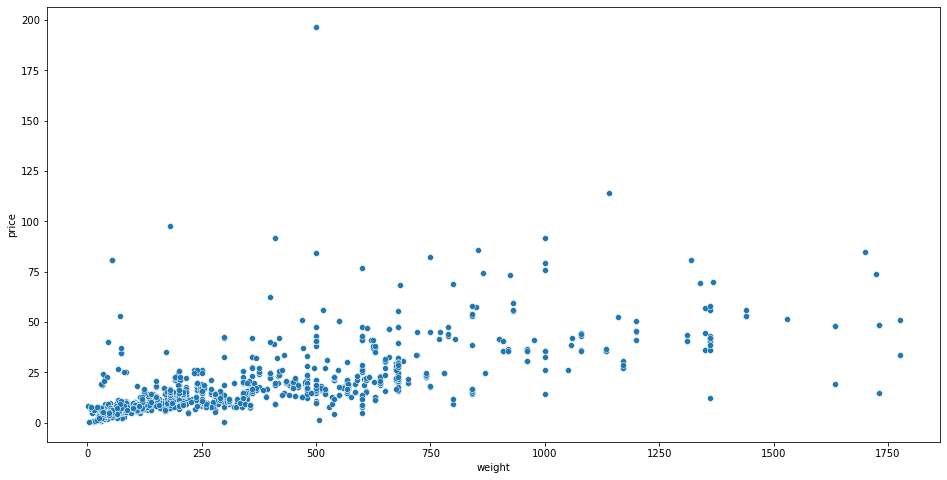

In [62]:
df = product_df.dropna()
df = df[(df['price'] <= 311) & (df['weight'] <= 1880)] # eval # default 1880
plt.figure(figsize=(16,8))
sns.scatterplot(x='weight', y='price', data=df)

In [63]:
# predict missing prices
lf = LinearRegression()
lf.fit(df['weight'].values.reshape(-1, 1), df['price'])

LinearRegression()

In [64]:
prices = lf.predict(product_df[product_df['price'].isnull()]['weight'].replace(np.nan, 1).values.reshape(-1, 1)) # .replace(np.nan, 1)

product_df.loc[product_df['price'].isnull(), 'price'] = prices

In [65]:
product_df[product_df['price'].isnull()]['weight'].sum() # test code

0.0

In [66]:
lf = LinearRegression()
lf.fit(df['price'].values.reshape(-1, 1), df['weight'])

LinearRegression()

In [67]:
weights = lf.predict(product_df[product_df['weight'].isnull()]['price'].values.reshape(-1, 1))

In [68]:
product_df.loc[product_df['weight'].isnull(), 'weight'].shape, weights.shape

((24,), (24,))

In [69]:
product_df.loc[product_df['weight'].isnull(), 'weight'] = weights

In [70]:
product_df.loc[product_df['weight'].isnull(), 'weight'].shape # not null

(0,)

In [71]:
product_df.isnull().sum()

Producto_ID        0
NombreProducto     0
popular_name       0
property           0
unit              24
pieces             0
in_train           0
in_test            0
weight             0
price              0
dtype: int64

In [72]:
product_df

,Producto_ID,NombreProducto,popular_name,property,unit,pieces,in_train,in_test,weight,price
0,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41,Bimbollos Ext sAjonjoli,BIM,480g,6,1,1,480.0,18.130000
1,53,Burritos Sincro 170g CU LON 53,Burritos Sincro,CU LON,170g,1,1,1,170.0,14.300000
2,72,Div Tira Mini Doradita 4p 45g TR 72,Div Tira Mini Doradita,TR,45g,4,1,1,45.0,3.700000
3,73,Pan Multigrano Linaza 540g BIM 73,Pan Multigrano Linaza,BIM,540g,1,1,1,540.0,21.320000
4,98,Tostado Integral 180g WON 98,Tostado Integral,WON,180g,1,0,1,180.0,11.298284
...,...,...,...,...,...,...,...,...,...,...
1727,49992,Tostado Integral 180g MTA WON 49992,Tostado Integral,MTA WON,180g,1,1,1,180.0,15.390000
1728,49993,Tostado Integral 180g TAB WON 49993,Tostado Integral,TAB WON,180g,1,1,1,180.0,16.200000
1729,49994,Tostado Int 0pct Grasa Azuc 200g WON 49994,Tostado Int 0pct Grasa Azuc,WON,200g,1,1,1,200.0,14.760000
1730,49996,Tostado Int 0pct Grasa Azuc 200g MTA WON 49996,Tostado Int 0pct Grasa Azuc,MTA WON,200g,1,1,1,200.0,14.760000


In [73]:
product_df[product_df['Producto_ID'].isnull()]

,Producto_ID,NombreProducto,popular_name,property,unit,pieces,in_train,in_test,weight,price


In [74]:
product_df[product_df['NombreProducto'].isnull()]

,Producto_ID,NombreProducto,popular_name,property,unit,pieces,in_train,in_test,weight,price


In [75]:
product_df[product_df['property'].isnull()]

,Producto_ID,NombreProducto,popular_name,property,unit,pieces,in_train,in_test,weight,price


In [76]:
# 上記で全てのnullが処理されている事が確認できる。

- 以下のdelを使用する為に、現在notebookで使用しているメモリを調べる構文を記述、処理を全てClass化するのであればメモリ使用量によってコードの挙動を変更するなどを行う。
- Pre-Process最終ラインで再度変数のメモリの確認を行っている。

In [77]:
""" import はLine1に加える
print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 10000: # これ以上のメモリ量の変数を取得する。
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))
"""
import sys
print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_"):
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|         CategoricalDtype|      1064|
|                  Counter|      1064|
|                       In|       776|
|         LinearRegression|      1472|
|                      Out|      1176|
|                 boxcox1p|       232|
|                client_df|  78952737|
|                     dask|        72|
|                      ddf|        72|
|                       df|    634532|
|                    dtype|       640|
|                     exit|        48|
|                    expon|        48|
|              get_ipython|        64|
|                       lf|        48|
|                       nl|       136|
|                     norm|        48|
|                       np|        72|
|                       pd|        72|
|                      plt|        72|
|                   prices|       376|
|                prices_df|     28928|
|               product_df|    665121|
|         product_price_d

In [78]:
# 必要のない変数は削除する。
del df
del prices
del weights

In [79]:

(product_df.drop(['unit'], axis=1).isnull().sum() == 0).all() # True is correct.

True

In [80]:
df = product_df.dropna()

In [81]:
(df['weight'] <= 1880).shape, (df['price'] <= 100).shape

((1708,), (1708,))

In [82]:
df.shape

(1708, 10)

In [83]:
df = df[(df['price'] <= 100) & (df['weight'] <= 1880)]

In [84]:
df.shape

(1682, 10)

In [85]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1732 entries, 0 to 1731
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Producto_ID     1732 non-null   int64  
 1   NombreProducto  1732 non-null   object 
 2   popular_name    1732 non-null   object 
 3   property        1732 non-null   object 
 4   unit            1708 non-null   object 
 5   pieces          1732 non-null   object 
 6   in_train        1732 non-null   int64  
 7   in_test         1732 non-null   int64  
 8   weight          1732 non-null   float64
 9   price           1732 non-null   float64
dtypes: float64(2), int64(3), object(5)
memory usage: 148.8+ KB


In [86]:
product_df['pieces'] = product_df['pieces'].astype('int16')
product_df['in_train'] = product_df['in_train'].astype('bool')
product_df['in_test'] = product_df['in_test'].astype('bool')
product_df['weight'] = product_df['weight'].astype('float32')
product_df['price'] = product_df['price'].astype('float32')

In [87]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1732 entries, 0 to 1731
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Producto_ID     1732 non-null   int64  
 1   NombreProducto  1732 non-null   object 
 2   popular_name    1732 non-null   object 
 3   property        1732 non-null   object 
 4   unit            1708 non-null   object 
 5   pieces          1732 non-null   int16  
 6   in_train        1732 non-null   bool   
 7   in_test         1732 non-null   bool   
 8   weight          1732 non-null   float32
 9   price           1732 non-null   float32
dtypes: bool(2), float32(2), int16(1), int64(1), object(4)
memory usage: 101.5+ KB


In [88]:
town_state_df['State'].dtype

dtype('O')

In [89]:
town_state_df['State'] = town_state_df['State'].astype('category')

In [90]:
town_state_df['State'].dtype

CategoricalDtype(categories=['AGUASCALIENTES', 'BAJA CALIFORNIA NORTE',
                  'BAJA CALIFORNIA SUR', 'CAMPECHE', 'CHIAPAS', 'CHIHUAHUA',
                  'COAHUILA', 'COLIMA', 'DURANGO', 'ESTADO DE MÉXICO',
                  'GUANAJUATO', 'GUERRERO', 'HIDALGO', 'JALISCO', 'MICHOACÁN',
                  'MORELOS', 'MÉXICO, D.F.', 'NAYARIT', 'NUEVO LEÓN', 'OAXACA',
                  'PUEBLA', 'QUERETARO', 'QUERETARO DE ARTEAGA',
                  'QUINTANA ROO', 'SAN LUIS POTOSÍ', 'SINALOA', 'SONORA',
                  'TABASCO', 'TAMAULIPAS', 'TLAXCALA', 'VERACRUZ', 'YUCATÁN',
                  'ZACATECAS'],
, ordered=False)

In [91]:
train_ddf['Canal_ID'].dtype, test_df['Canal_ID'].dtype, test_ddf['Canal_ID'].dtype

(dtype('int64'), dtype('int8'), dtype('int64'))

In [92]:
train_ddf['Canal_ID'] = train_ddf['Canal_ID'].astype('category')
test_ddf['Canal_ID'] = test_ddf['Canal_ID'].astype('category')

In [93]:
#train_df.drop(['Venta_uni_hoy', 'Venta_hoy', 'Dev_uni_proxima', 'Dev_proxima'], axis=1, inplace=True)
train_ddf = train_ddf.drop(['Venta_uni_hoy', 'Venta_hoy', 'Dev_uni_proxima', 'Dev_proxima'], axis=1)

# Merge

In [94]:
train_df = train_ddf.merge(town_state_df[['Agencia_ID', 'Town_ID']], how='left')

In [95]:
test_df = test_ddf.merge(town_state_df[['Agencia_ID', 'Town_ID']], how='left')

In [96]:
train_df = train_df.drop('Agencia_ID', axis=1)

In [97]:
test_df = test_df.drop('Agencia_ID', axis=1)

In [98]:
#train_df = pd.merge(train_ddf, town_state_df[['Agencia_ID', 'Town_ID']], how='left')
#test_df = pd.merge(test_ddf, town_state_df[['Agencia_ID', 'Town_ID']], how='left')
#train_ddf.drop('Agencia_ID', axis=1, inplace=True)
#train_df.drop('Agencia_ID', axis=1, inplace=True)
#test_df.drop('Agencia_ID', axis=1, inplace=True)

In [99]:
train_df = train_df.merge(product_df[[
        'Producto_ID', 'popular_name', 'property',
        'pieces', 'weight', 'price'
    ]], how='left')

test_df = test_df.merge(product_df[[
        'Producto_ID', 'popular_name', 'property',
        'pieces', 'weight', 'price'
    ]], how='left')

In [100]:
train_df # Demanda_uni_equil

,Semana,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,Town_ID,popular_name,property,pieces,weight,price
npartitions=128,,,,,,,,,,,,
,int64,category[unknown],int64,int64,int64,int64,int16,object,object,int16,float32,float32
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


In [101]:
test_df

,id,Semana,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Town_ID,popular_name,property,pieces,weight,price
npartitions=11,,,,,,,,,,,,
,int64,int64,category[unknown],int64,int64,int64,int16,object,object,int16,float32,float32
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


In [102]:
#train_df = pd.merge(
#    train_df,
#    product_df[[
#        'Producto_ID', 'popular_name', 'property',
#        'pieces', 'weight', 'price'
#    ]], how='left')
#test_df = pd.merge(
#    test_df,
#    product_df[[
#        'Producto_ID', 'popular_name', 'property',
#        'pieces', 'weight', 'price'
#    ]], how='left')

In [103]:
train_df['Semana'].dtype, train_df['Demanda_uni_equil'].dtype

(dtype('int64'), dtype('int64'))

In [104]:
semana_med_s = train_df.groupby('Semana')['Demanda_uni_equil'].apply(pd.Series.median, meta={'semana_med_s': 'int64'}) # .median() metaはint64で多分大丈夫のはず

In [105]:
semana_med_s

,semana_med_s
npartitions=128,
,int64
,...
...,...
,...
,...


# Dask.DataFrame - drop(inplace=True)について
- Dask.DataFrameのdropはinplaceに対応していない

In [106]:
train_df = train_df.drop('Semana', axis=1)
test_df = test_df.drop('Semana', axis=1)

In [107]:
#train_df.drop('Semana', axis=1, inplace=True)
#test_df.drop('Semana', axis=1, inplace=True)
del semana_med_s

#### Client_ID

In [108]:
client_med_s = train_df.groupby('Cliente_ID')['Demanda_uni_equil'].apply(pd.Series.median, meta={'client_med': 'int16'}) #.astype('int16')
client_med_s.name = 'client_med'

#### Popular_name

In [109]:
popular_name_med_s = train_df.groupby('popular_name')['Demanda_uni_equil'].apply(pd.Series.median, meta={'popular_name_med': 'int16'}) #.astype('int16')
popular_name_med_s.name = 'popular_name_med'

#### Town_ID

In [110]:
train_df

,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,Town_ID,popular_name,property,pieces,weight,price
npartitions=128,,,,,,,,,,,
,category[unknown],int64,int64,int64,int64,int16,object,object,int16,float32,float32
,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


In [111]:
town_id_med_s = train_df.groupby('Town_ID')['Demanda_uni_equil'].apply(pd.Series.median, meta={'town_id_med': 'int16'}) #.astype('int16')
town_id_med_s.name = 'town_id_med'

#### Ruta_SAK

In [112]:
ruta_id_med_s = train_df.groupby('Ruta_SAK')['Demanda_uni_equil'].apply(pd.Series.median, meta={'ruta_id_med': 'int16'}) #.astype('int16')
ruta_id_med_s.name = 'ruta_id_med'

### Merging

In [113]:
train_df = train_df.merge(client_med_s.reset_index(), how='left')
train_df = train_df.merge(popular_name_med_s.reset_index(), how='left')
train_df = train_df.merge(town_id_med_s.reset_index(), how='left')
train_df = train_df.merge(ruta_id_med_s.reset_index(), how='left')

C:\Anaconda3\envs\Machine_Learning\lib\site-packages\dask\dataframe\multi.py:456: UserWarning: Merging dataframes with merge column data type mismatches: 
+--------------------+------------+-------------+
| Merge columns      | left dtype | right dtype |
+--------------------+------------+-------------+
| ('index', 'index') | float64    | int64       |
+--------------------+------------+-------------+
Cast dtypes explicitly to avoid unexpected results.
  warnings.warn(


In [114]:
test_df = test_df.merge(client_med_s.reset_index(), how='left')
test_df = test_df.merge(popular_name_med_s.reset_index(), how='left')
test_df = test_df.merge(town_id_med_s.reset_index(), how='left')
test_df = test_df.merge(ruta_id_med_s.reset_index(), how='left')

In [115]:
test_df['popular_name_med'] = test_df['popular_name_med'].fillna(test_df['popular_name_med'].mean())
test_df['client_med'] = test_df['client_med'].fillna(test_df['client_med'].mean())
test_df['ruta_id_med'] = test_df['ruta_id_med'].fillna(test_df['ruta_id_med'].mean())

In [116]:
# 下のtest_dfとセット
train_df['client_med'] = train_df['client_med'].astype('int16')
train_df['popular_name_med'] = train_df['popular_name_med'].astype('int16')
train_df['town_id_med'] = train_df['town_id_med'].astype('int16')
train_df['ruta_id_med'] = train_df['ruta_id_med'].astype('int16')

In [117]:
test_df['client_med'] = test_df['client_med'].astype('int16')
test_df['popular_name_med'] = test_df['popular_name_med'].astype('int16')
test_df['town_id_med'] = test_df['town_id_med'].astype('int16')
test_df['ruta_id_med'] = test_df['ruta_id_med'].astype('int16')

In [118]:
test_df['popular_name_med'] = test_df['popular_name_med'].fillna(test_df['popular_name_med'].mean())
test_df['client_med'] = test_df['client_med'].fillna(test_df['client_med'].mean())
test_df['ruta_id_med'] = test_df['ruta_id_med'].fillna(test_df['ruta_id_med'].mean())

In [119]:
train_df['client_med'] = train_df['client_med'].astype('int16')
train_df['popular_name_med'] = train_df['popular_name_med'].astype('int16')
train_df['town_id_med'] = train_df['town_id_med'].astype('int16')
train_df['ruta_id_med'] = train_df['ruta_id_med'].astype('int16')

In [120]:
test_df['client_med'] = test_df['client_med'].astype('int16')
test_df['popular_name_med'] = test_df['popular_name_med'].astype('int16')
test_df['town_id_med'] = test_df['town_id_med'].astype('int16')
test_df['ruta_id_med'] = test_df['ruta_id_med'].astype('int16')

In [121]:
test_df.isnull().sum() # 代入する必要のない変数に不用意に代入した場合、Error

Dask Series Structure:
npartitions=1
Canal_ID    int64
weight        ...
dtype: int64
Dask Name: dataframe-sum-agg, 18882 tasks

In [122]:
#train_df.drop(
#    ['Ruta_SAK', 'Cliente_ID', 'Producto_ID', 'Town_ID', 'popular_name', 'property', 'pieces'],
#    axis=1, inplace=True)
#test_df.drop(
#    ['Ruta_SAK', 'Cliente_ID', 'Producto_ID', 'Town_ID', 'popular_name', 'property', 'pieces'],
#    axis=1, inplace=True)

In [123]:
train_df = train_df.drop(['Ruta_SAK', 'Cliente_ID', 'Producto_ID', 'Town_ID', 'popular_name', 'property', 'pieces'], axis=1)
test_df = test_df.drop(['Ruta_SAK', 'Cliente_ID', 'Producto_ID', 'Town_ID', 'popular_name', 'property', 'pieces'], axis=1)

In [124]:
train_df

,Canal_ID,Demanda_uni_equil,weight,price,index,client_med,popular_name_med,town_id_med,ruta_id_med
npartitions=128,,,,,,,,,
,category[unknown],int64,float32,float32,float64,int16,int16,int16,int16
,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...


In [125]:
test_df

,id,Canal_ID,weight,price,index,client_med,popular_name_med,town_id_med,ruta_id_med
npartitions=128,,,,,,,,,
,int64,category[unknown],float32,float32,float64,int16,int16,int16,int16
,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...


In [126]:
train_df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 9 entries, Canal_ID to ruta_id_med
dtypes: category(1), float32(2), float64(1), int16(4), int64(1)

In [127]:
test_df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 9 entries, id to ruta_id_med
dtypes: category(1), float32(2), float64(1), int16(4), int64(1)

In [128]:
train_df.describe()

,Demanda_uni_equil,weight,price,index,client_med,popular_name_med,town_id_med,ruta_id_med
npartitions=1,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...


In [129]:
test_df.describe()

,id,weight,price,index,client_med,popular_name_med,town_id_med,ruta_id_med
npartitions=1,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...


---------
>これより下に続く処理を実行する為に一度メモリの使用状況を確認しておく。必要であれば不要な変数を削除する。

In [130]:
print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_"):
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|         CategoricalDtype|      1064|
|                  Counter|      1064|
|                       In|      1264|
|         LinearRegression|      1472|
|                      Out|      2272|
|                 boxcox1p|       232|
|                client_df|  78952737|
|             client_med_s|        48|
|                     dask|        72|
|                      ddf|        72|
|                       df|    646777|
|                    dtype|       640|
|                     exit|        48|
|                    expon|        48|
|              get_ipython|        64|
|                       lf|        48|
|                       nl|       136|
|                     norm|        48|
|                       np|        72|
|                       pd|        72|
|                      plt|        72|
|       popular_name_med_s|        48|
|                prices_df|     28928|
|               product_d

In [131]:
del sale_prices_df
del product_price_df
del return_prices_df
del client_df

In [132]:
print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_"):
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|         CategoricalDtype|      1064|
|                  Counter|      1064|
|                       In|      1264|
|         LinearRegression|      1472|
|                      Out|      2272|
|                 boxcox1p|       232|
|             client_med_s|        48|
|                     dask|        72|
|                      ddf|        72|
|                       df|    646777|
|                    dtype|       640|
|                     exit|        48|
|                    expon|        48|
|              get_ipython|        64|
|                       lf|        48|
|                       nl|       136|
|                     norm|        48|
|                       np|        72|
|                       pd|        72|
|                      plt|        72|
|       popular_name_med_s|        48|
|                prices_df|     28928|
|               product_df|    550020|
|                     qui

In [137]:
store = pd.HDFStore('test.h5')

ImportError: Missing optional dependency 'tables'.  Use pip or conda to install tables.